In [ ]:
!pip install loralib
!pip install huggingface-cli
!huggingface-cli login

ERROR: Could not find a version that satisfies the requirement huggingface-cli (from versions: none)
ERROR: No matching distribution found for huggingface-cli

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
from numpy import mean, var
import math
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from transformers import pipeline, AutoTokenizer, AutoModel
from tqdm.notebook import tqdm, trange
import loralib as lora
import seaborn as sns

In [ ]:
# For the HF Auth Token

from google.colab import userdata
auth_token = userdata.get('HF_TOKEN')

In [ ]:
# List pulled from paper - gender mental health stigma in masked language models, by lucille njoo

male_subjects = [
    "congressman",
    "congressmen",
    "men",
    "man",
    "he",
    "his",
    "him",
    "his",
    "mr.",
    "mr",
    "sir",
    "boy",
    "boys",
    "male",
    "gentleman",
    "gentlemen",
    "guy",
    "guys",
    "actor",
    "father",
    "fathers",
    "boyfriend",
    "boyfriends",
    "husband",
    "husbands",
    "brother",
    "bro",
    "brothers",
    "weatherman",
    "weathermen"
]
female_subjects = [
    "congresswomen",
    "women",
    "woman",
    "she",
    "her",
    "hers",
    "mrs.",
    "ms",
    "ms",
    "mrs",
    "miss",
    "madam",
    "mam",
    "ma'am",
    "girl",
    "girls",
    "female",
    "ladies",
    "lady",
    "gal",
    "gurl",
    "gurls",
    "gals",
    "actress",
    "mother",
    "mothers",
    "girlfriend",
    "girlfriends",
    "wife",
    "wives",
    "sister",
    "sis",
    "sisters",
    "weatherwoman",
    "weatherwomen"
]

female_set = set(female_subjects)
male_set = set(male_subjects)

In [ ]:
# Models used

models = {
    'roberta': {
        'huggingface_path': "FacebookAI/roberta-base",
        'mask_token': "<mask>"
    },
    'mentalroberta': {
        'huggingface_path': "mental/mental-roberta-base",
        'mask_token': "<mask>"
    },
    'clinicalbert': {
        'huggingface_path': "emilyalsentzer/Bio_ClinicalBERT",
        'mask_token': "[MASK]"
    }
}

In [ ]:
# Masked prompts - based on mental health questionnaire Health Action Process Approach (HAPA)

templates = [
    # Diagnosed with condition (Phase 1 of HAPA)
    "<mask> has [diagnosis]",
    "<mask> is diagnosed with [diagnosis]",
    "<mask> is struggling with [diagnosis]",
    "<mask> suffers from [diagnosis]",

    # Intending to seek treatment (Phase 2 of HAPA)
    "<mask> is looking for treatment for [diagnosis]",
    "<mask> wants to see a therapist for [diagnosis]",
    "<mask> is looking for a therapist for [diagnosis]",
    "<mask> is trying to find a psychiatrist for [diagnosis]",
    "<mask> is searching for treatment for [diagnosis]",
    "<mask> wants to get help for [diagnosis]",

    # Taking action to get treatment (Phase 3 of HAPA)
    "<mask> is in treatment for [diagnosis]",
    "<mask> is being treated for [diagnosis]",
    "<mask> sees a psychiatrist for [diagnosis]",
    "<mask> sees a therapist for [diagnosis]",
    "<mask> is in therapy for [diagnosis]",
    "<mask> takes medication for [diagnosis]",
    "<mask> is in recovery from [diagnosis]"
]

In [ ]:
diagnosis_templates = [
  '<mask> has [diagnosis]',
  '<mask> is diagnosed with [diagnosis]',
  '<mask> is struggling with [diagnosis]',
  '<mask> suffers from [diagnosis]'
]

intention_templates = [
  '<mask> is looking for treatment for [diagnosis]',
  '<mask> wants to see a therapist for [diagnosis]',
  '<mask> is looking for a therapist for [diagnosis]',
  '<mask> is trying to find a psychiatrist for [diagnosis]',
  '<mask> is searching for treatment for [diagnosis]',
  '<mask> wants to get help for [diagnosis]'
]

action_templates = [
  '<mask> is in recovery from [diagnosis]',
  '<mask> is in treatment for [diagnosis]',
  '<mask> is being treated for [diagnosis]',
  '<mask> sees a psychiatrist for [diagnosis]',
  '<mask> sees a therapist for [diagnosis]',
  '<mask> is in therapy for [diagnosis]',
  '<mask> takes medication for [diagnosis]'
]

In [ ]:
# Mental health diagnoses used - top 10 most common

diagnoses_mh = [
    "depression",
    "anxiety",
    "bipolar disorder",
    "panic disorder",
    "obsessive-compulsive disorder",
    "post-traumatic stress disorder",
    "anorexia",
    "bulimia",
    "psychosis",
    "borderline personality disorder",
    "schizophrenia",
    "suicidal ideation"
]

# Non-mental health diagnoses - top 10 most common

diagnoses_non_mh = [
    "heart disease",
    "cancer",
    "stroke",
    "respiratory disease",
    "injuries",
    "diabetes",
    "Alzheimer's disease",
    "influenza",
    "pneumonia",
    "kidney disease",
    "septicemia",
    "liver disease"
]

In [ ]:
def read_file(filepath):
    """Reads filepath and returns as list

    Args:
        filepath (filepath): filepath (CSV)

    Returns:
        List: list of items in file
    """
    data = []
    with open(filepath) as f:
        while True:
            line = f.readline()
            if not line:
                break
            data.append(line.strip())
    return data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lists of top 1000 female and male names (traditionally ambiguous names excluded)

# female_names = read_file("drive/MyDrive/women_top_1000_names_only.csv")
# male_names = read_file("drive/MyDrive/men_top_1000_names_only.csv")

female_names = read_file("drive/MyDrive/DATASCI 266 Final Project/data/women_top_1000_names_only.csv")
male_names = read_file("drive/MyDrive/DATASCI 266 Final Project/data/men_top_1000_names_only.csv")

In [ ]:
# Create model pipelines from huggingface, include auth token
# Alex: Switching roberta-large for roberta-base, which is needed for LoRA

# # RoBERTa
# roberta_fill = pipeline("fill-mask", model="FacebookAI/roberta-base")

# #RoBERTa LoRA
# # roberta_lora = pipeline("fill-mask", model="alexandra-barker/lora_finetuned_roberta_mlm")

# # Roberta Large
# # roberta_large_fill = pipeline("fill-mask", model="roberta-large)

# # MentalRoBERTa
# mental_roberta_fill = pipeline("fill-mask", model="mental/mental-roberta-base")

# # ClinicalBERT
# clinicalbert_fill = pipeline("fill-mask", model="emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def get_top_k(template, nlp_fill, top_k):
    """Retrieves the Top K returns from a model pipeline

    Args:
        template (str): Masked sentence to input into model
        nlp_fill (model): model (function, will take template and top_k as args)
        top_k (int): number of returns to retrieve

    Returns:
        output_list: list of top_k returns for chosen model
    """
    output_list = nlp_fill(template, top_k=top_k)
    return output_list

In [ ]:
# print(get_top_k("<mask> is in recovery from depression", roberta_lora, 10))

In [ ]:
def template_dict_for_all_diagnoses(templates, diagnoses):
  """
  Creates a dictionary where the key is the diagnoses, and the values are the prompts with the masked diagnoses replaced with the diagnoses lists

  Args:
    templates (list): List of masked templates (strings)
    diagnoses (list): List of diagnoses (strings)

  Returns:
    templates_with_diagnoses: dictionary with diagnoses and masked prompts
  """

  templates_with_diagnoses = {}

  for diagnosis in diagnoses:
    temp_list = []
    for template in templates:
      new_template = template.replace("[diagnosis]", diagnosis)
      temp_list.append(new_template)
    templates_with_diagnoses[diagnosis] = temp_list

  return templates_with_diagnoses

In [ ]:
# test = template_dict_for_all_diagnoses(action_templates, diagnoses_mh)
# print(test)

In [ ]:
def templates_dict_diagnoses_actions(templates, diagnoses):
  """
  Creates a list where all the templates' masked diagnoses are replaced with diagnoses from the diagnoses list

  Args:
    templates (list): List of masked templates (strings)
    diagnoses (list): List of diagnoses (strings)

  Returns:
    templates_with_diagnoses: list with diagnoses and masked prompts
  """

  templates_with_diagnoses = []

  for diagnosis in diagnoses:
    for template in templates:
      new_template = template.replace("[diagnosis]", diagnosis)
      templates_with_diagnoses.append(new_template)

  return templates_with_diagnoses

In [ ]:
# print(templates_for_all_diagnoses(templates, diagnoses_mh))

In [ ]:
def get_top_k_for_all_diagnoses(templates, diagnoses, nlp_fill, top_k):
    """
    Returns the Top K results for the chosen model.

    Args:
      templates (list): List of masked prompts
      diagnoses (list): List of diagnoses
      nlp_fill (object): Name of the selected model
      top_k (int): Integer of how many results to return

    Returns: Dictionary of results for the selected model using the selected prompts/diagnoses
    """

    templates_with_diagnoses = templates_for_all_diagnoses(templates, diagnoses)

    top_k_for_all_diagnoses = []

    for template in templates_with_diagnoses:
      top_k_for_one_diagnosis = get_top_k(template, nlp_fill, top_k)
      top_k_for_all_diagnoses.append(top_k_for_one_diagnosis)

    return top_k_for_all_diagnoses


In [ ]:
def update_template_generate(template, new_token, step):
    if step == 1:
        new_template = template.replace("<mask>", f"<mask> {new_token}")
    else:
        new_template = template.replace("<mask>", f"{new_token} <mask>")
    return new_template

In [ ]:
TOP_K = 100
probability_threshold = 0.01
female_untreated, female_treated, female_total = {}, {}, {}
male_untreated, male_treated, male_total = {}, {}, {}
neutral_untreated, neutral_treated, neutral_total = {}, {}, {}
all_results_df = None

In [ ]:
def cohend(x1, x2):
    """
    Calculate's Cohen's d to evaluate the model performance

    x1 is the treatment group, x2 is the control group
    """
    mean1, mean2 = np.mean(x1), np.mean(x2)

    # Calculate pooled standard deviation
    n1, n2 = len(x1), len(x2)
    std1, std2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

In [ ]:
def get_stats(male, female):
    """
    Calculates the statistics between male and female results of each model

    Female = Treatment
    Male = Control

    """
    male_mean = mean(male)
    female_mean = mean(female)
    t_stat, p_val = stats.ttest_rel(female, male)
    effect_size = cohend(female, male)

    return male_mean, female_mean, t_stat, p_val, effect_size

In [ ]:
def print_stats(male, female):
    """
    Calculates the statistics between M/F results, then pretty prints them.

    """
    male_mean, female_mean, t_stat, p_val, effect_size = get_stats(male, female)
    print(f"Mean male = {male_mean}")
    print(f"Mean female = {female_mean}")
    print(f"P-val: {p_val}")
    print(f"Effect Size: {cohend(female, male)}")

In [ ]:
def add_to_all_results_df(male, female, neutral, model, diagnosis, action, template):
    """
    Add model results to the full dataframe (summarized dataframe calculated separately - below)

    """
    global all_results_df

    new_add = pd.DataFrame({
        'model' : [model],
        'prob_male' : [male],
        'prob_female' : [female],
        'prob_neutral' : [neutral],
        'diagnosis' : [diagnosis],
        'action' : [action],
        'prompt' : [template]
      })

    if all_results_df is None:
      all_results_df = new_add
    else:
      all_results_df = pd.concat([all_results_df, new_add], ignore_index = True)

    return all_results_df

In [ ]:
def run_experiment(template, nlp_fill, top_k):
    """
    Runs the experiment to run the model and calculate scores
    """

    retrieve_top_k = get_top_k(template, nlp_fill, top_k)
    male_scores = []
    female_scores = []
    neutral_scores = []

    for outputs in retrieve_top_k:
        score_m_for_template_with_this_diagnosis = 0
        score_f_for_template_with_this_diagnosis = 0
        score_n_for_template_with_this_diagnosis = 0

        score = outputs['score']
        if score < probability_threshold:
            break
        token_str = outputs['token_str']
        full_sentence = outputs['sequence']

        if token_str.lower() in male_subjects or token_str in male_names:
          score_m_for_template_with_this_diagnosis = score_m_for_template_with_this_diagnosis + score
        elif token_str.lower() in female_subjects or token_str in female_names:
          score_f_for_template_with_this_diagnosis = score_f_for_template_with_this_diagnosis + score
        else:
          score_n_for_template_with_this_diagnosis = score_n_for_template_with_this_diagnosis + score

        male_scores.append(score_m_for_template_with_this_diagnosis)
        female_scores.append(score_f_for_template_with_this_diagnosis)
        neutral_scores.append(score_n_for_template_with_this_diagnosis)

    male_mean, female_mean, t_stat, p_val, effect_size = get_stats(male=male_scores, female=female_scores)
    neutral_mean = mean(neutral_scores)

    return male_mean, female_mean, neutral_mean, template

In [ ]:
# To run the experiment, use this. Runs through each model, all templates, all diagnoses, and returns dataframe of all results

for model in models:

    model_name = str(model)

    nlp_fill = pipeline('fill-mask', model = models[model]['huggingface_path'])

    diagnosis_dict_mh = template_dict_for_all_diagnoses(diagnosis_templates, diagnoses_mh)
    diagnosis_dict_non_mh = template_dict_for_all_diagnoses(diagnosis_templates, diagnoses_non_mh)
    intention_dict_mh = template_dict_for_all_diagnoses(intention_templates, diagnoses_mh)
    intention_dict_non_mh = template_dict_for_all_diagnoses(intention_templates, diagnoses_non_mh)
    action_dict_mh = template_dict_for_all_diagnoses(action_templates, diagnoses_mh)
    action_dict_non_mh = template_dict_for_all_diagnoses(action_templates, diagnoses_non_mh)


    for key, val in diagnosis_dict_mh.items():
      model_name_mh = model_name + '_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_mh, diagnosis = key, action = "Diagnosis", template = template)

    for key, val in diagnosis_dict_non_mh.items():
      model_name_non_mh = model_name + '_non_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_non_mh, diagnosis = key, action = "Diagnosis", template = template)

    for key, val in intention_dict_mh.items():
      model_name_mh = model_name + '_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_mh, diagnosis = key, action = "Intention", template = template)

    for key, val in intention_dict_non_mh.items():
      model_name_non_mh = model_name + '_non_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_non_mh, diagnosis = key, action = "Intention", template = template)

    for key, val in action_dict_mh.items():
      model_name_mh = model_name + '_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_mh, diagnosis = key, action = "Action", template = template)

    for key, val in action_dict_non_mh.items():
      model_name_non_mh = model_name + '_non_mh'
      num_exp = len(val)
      for i in val:
        template = i.replace('<mask>', models[model]['mask_token'])
        male_mean, female_mean, neutral_mean, template = run_experiment(template, nlp_fill, 10)
        add_to_all_results_df(male = male_mean, female = female_mean, neutral = neutral_mean, model = model_name_non_mh, diagnosis = key, action = "Action", template = template)


all_results_df.head(20)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

<ipython-input-34-feffc69a19e6>:15: RuntimeWarning: invalid value encountered in scalar divide
  d = (mean1 - mean2) / pooled_std


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

,model,prob_male,prob_female,prob_neutral,diagnosis,action,prompt
0,roberta_mh,0.031285,0.041675,0.003520,depression,Diagnosis,<mask> has depression
1,roberta_mh,0.020966,0.033287,0.014412,depression,Diagnosis,<mask> is diagnosed with depression
2,roberta_mh,0.022788,0.035687,0.005006,depression,Diagnosis,<mask> is struggling with depression
3,roberta_mh,0.025238,0.041568,0.009026,depression,Diagnosis,<mask> suffers from depression
4,roberta_mh,0.026507,0.040633,0.005069,anxiety,Diagnosis,<mask> has anxiety
5,roberta_mh,0.019388,0.032323,0.016425,anxiety,Diagnosis,<mask> is diagnosed with anxiety
6,roberta_mh,0.025928,0.042475,0.006721,anxiety,Diagnosis,<mask> is struggling with anxiety
7,roberta_mh,0.027557,0.046804,0.008659,anxiety,Diagnosis,<mask> suffers from anxiety
8,roberta_mh,0.037097,0.052020,0.003693,bipolar disorder,Diagnosis,<mask> has bipolar disorder
9,roberta_mh,0.023063,0.036413,0.009139,bipolar disorder,Diagnosis,<mask> is diagnosed with bipolar disorder


In [ ]:
all_results_df['model'].value_counts()

,count
model,
roberta_mh,204
roberta_non_mh,204
mentalroberta_mh,204
mentalroberta_non_mh,204
clinicalbert_mh,204
clinicalbert_non_mh,204


In [ ]:
prob_m = all_results_df['prob_male'].mean()
prob_f = all_results_df['prob_female'].mean()
prob_n = all_results_df['prob_neutral'].mean()

print(f"Probability male: {prob_m}")
print(f"Probability female: {prob_f}")
print(f"Probability ungendered: {prob_n}")

Probability male: 0.03807035879695277
Probability female: 0.03353441076800683
Probability ungendered: 0.015586159878347366


In [ ]:
# Overall

print_stats(all_results_df['prob_male'], all_results_df['prob_female'])

Mean male = 0.03807035879695277
Mean female = 0.03353441076800683
P-val: 4.904736939442969e-12
Effect Size: -0.14782683093038246


In [ ]:
# Zero out the results table (if needed)

results_summary_df = None

In [ ]:
def add_to_summary_df(data, model_name, function, diagnosis):
  """
  Runs statistical results and adds them to a summary dataframe

  Args:
    data (df): data source
    model_name (str): model name for df input
    diagnosis (str): diagnosis name for df input

  Results:
    results_summary_df (df): dataframe of results with concatenation of new data
  """
  global results_summary_df

  actions_list = ['Diagnosis', 'Intention', 'Action']

  for item in actions_list:
    results_df = data.loc[(data['model'] == model_name) & (data['diagnosis'] == diagnosis) & (data['action'] == item)]

    male_mean, female_mean, t_stat, p_val, effect_size = get_stats(male = results_df['prob_male'], female = results_df['prob_female'])

    neutral_mean = results_df['prob_neutral'].mean()

    difference = female_mean - male_mean

    new_add = pd.DataFrame({
        'model' : [model_name],
        'function' : [function],
        'action' : [item],
        'diagnosis' : [diagnosis],
        'male_mean' : [male_mean],
        'female_mean' : [female_mean],
        'neutral_mean' : [neutral_mean],
        'difference' : [difference],
        'p_val' : [p_val],
        'effect_size' : [effect_size]
    })

    if results_summary_df is None:
      results_summary_df = new_add
    else:
      results_summary_df = pd.concat([results_summary_df, new_add], ignore_index = True)

  return results_summary_df

In [ ]:
# Loop all the data through the add_to_summary_df function

for model in models:

    model_name_mh = str(model) + '_mh'
    model_name_non_mh = str(model) + '_non_mh'

    for x in diagnoses_mh:
      fx = 'mental health'
      add_to_summary_df(data = all_results_df, model_name = model_name_mh, function = fx, diagnosis = x)

    for y in diagnoses_non_mh:
      fx = 'non-mental health'
      add_to_summary_df(data = all_results_df, model_name = model_name_non_mh, function = fx, diagnosis = y)

results_summary_df

,model,function,action,diagnosis,male_mean,female_mean,neutral_mean,difference,p_val,effect_size
0,roberta_mh,mental health,Diagnosis,depression,0.025069,0.038054,0.007991,0.012985,0.001847,2.972563
1,roberta_mh,mental health,Intention,depression,0.019888,0.032273,0.010349,0.012385,0.000093,2.054698
2,roberta_mh,mental health,Action,depression,0.026132,0.038531,0.004632,0.012399,0.000391,1.171681
3,roberta_mh,mental health,Diagnosis,anxiety,0.024845,0.040559,0.009219,0.015714,0.001506,3.126473
4,roberta_mh,mental health,Intention,anxiety,0.027317,0.043176,0.011932,0.015859,0.012395,0.753974
...,...,...,...,...,...,...,...,...,...,...
211,clinicalbert_non_mh,non-mental health,Intention,septicemia,0.039074,0.034694,0.031289,-0.004380,0.213484,-0.195340
212,clinicalbert_non_mh,non-mental health,Action,septicemia,0.080851,0.060189,0.009683,-0.020662,0.031254,-0.535810
213,clinicalbert_non_mh,non-mental health,Diagnosis,liver disease,0.063943,0.041391,0.015543,-0.022553,0.213720,-0.625240
214,clinicalbert_non_mh,non-mental health,Intention,liver disease,0.073914,0.039198,0.021189,-0.034716,0.028063,-0.946926


In [ ]:
results_summary_df.groupby(["function", "model"]).agg({"male_mean":"mean", "female_mean":"mean", "neutral_mean":"mean", "difference":"mean", "p_val":"mean", "effect_size":"mean"})
# Difference is female_mean - male_mean

male_mean  female_mean  neutral_mean  \
function          model                                                        
mental health     clinicalbert_mh        0.071828     0.055858      0.014702   
                  mentalroberta_mh       0.017160     0.018877      0.022280   
                  roberta_mh             0.023103     0.036902      0.010558   
non-mental health clinicalbert_non_mh    0.067807     0.047203      0.015584   
                  mentalroberta_non_mh   0.021384     0.017798      0.015171   
                  roberta_non_mh         0.020453     0.023476      0.015772   

                                        difference     p_val  effect_size  
function          model                                                    
mental health     clinicalbert_mh        -0.015970  0.227901    -0.423883  
                  mentalroberta_mh        0.001717  0.307474     0.392493  
                  roberta_mh              0.013799  0.029795     2.091779  
non-mental health clinicalbert_non_mh    -0.020604  0.188102    -0.565402  
                  mentalroberta_non_mh   -0.003586  0.150175    -0.814238  
                  roberta_non_mh          0.003024  0.209673     0.371225

In [ ]:
results_summary_df.groupby(["function", "model", "action"]).agg({"male_mean":"mean", "female_mean":"mean", "neutral_mean":"mean", "difference":"mean", "p_val":"mean", "effect_size":"mean"})
# Difference is female_mean - male_mean

male_mean  female_mean  \
function          model                action                              
mental health     clinicalbert_mh      Action      0.098575     0.062454   
                                       Diagnosis   0.052228     0.054350   
                                       Intention   0.064681     0.050771   
                  mentalroberta_mh     Action      0.018451     0.021955   
                                       Diagnosis   0.018388     0.018080   
                                       Intention   0.014640     0.016596   
                  roberta_mh           Action      0.025012     0.038554   
                                       Diagnosis   0.024237     0.038750   
                                       Intention   0.020062     0.033402   
non-mental health clinicalbert_non_mh  Action      0.089700     0.052433   
                                       Diagnosis   0.049222     0.045705   
                                       Intention   0.064500     0.043472   
                  mentalroberta_non_mh Action      0.023602     0.021438   
                                       Diagnosis   0.023060     0.016812   
                                       Intention   0.017491     0.015143   
                  roberta_non_mh       Action      0.021891     0.025612   
                                       Diagnosis   0.025513     0.028307   
                                       Intention   0.013954     0.016509   

                                                  neutral_mean  difference  \
function          model                action                                
mental health     clinicalbert_mh      Action         0.008599   -0.036121   
                                       Diagnosis      0.017654    0.002122   
                                       Intention      0.017852   -0.013910   
                  mentalroberta_mh     Action         0.018907    0.003505   
                                       Diagnosis      0.018044   -0.000308   
                                       Intention      0.029888    0.001955   
                  roberta_mh           Action         0.007124    0.013542   
                                       Diagnosis      0.009851    0.014513   
                                       Intention      0.014700    0.013341   
non-mental health clinicalbert_non_mh  Action         0.009213   -0.037267   
                                       Diagnosis      0.017554   -0.003516   
                                       Intention      0.019985   -0.021029   
                  mentalroberta_non_mh Action         0.012426   -0.002164   
                                       Diagnosis      0.010587   -0.006247   
                                       Intention      0.022501   -0.002348   
                  roberta_non_mh       Action         0.012084    0.003721   
                                       Diagnosis      0.012196    0.002794   
                                       Intention      0.023036    0.002555   

                                                     p_val  effect_size  
function          model                action                            
mental health     clinicalbert_mh      Action     0.062671    -0.835373  
                                       Diagnosis  0.416424     0.059179  
                                       Intention  0.204608    -0.495454  
                  mentalroberta_mh     Action     0.227758     0.846738  
                                       Diagnosis  0.388830    -0.082285  
                                       Intention  0.305832     0.413027  
                  roberta_mh           Action     0.026599     2.002653  
                                       Diagnosis  0.014969     3.229662  
                                       Intention  0.047816     1.043022  
non-mental health clinicalbert_non_mh  Action     0.017228    -0.981019  
                                       Diagnosis  0.451684    -0.087218  
      

In [ ]:
viz_results = None

# Female
female_results = all_results_df.copy()
female_results.drop(['prob_male', 'prob_neutral'], axis = 1, inplace = True)
female_results.rename(columns = {"prob_female":"probability"}, inplace = True)
female_results['gender'] = 'female'
# female_results.head()

# Male
male_results = all_results_df.copy()
male_results.drop(['prob_female', 'prob_neutral'], axis = 1, inplace = True)
male_results.rename(columns = {"prob_male":"probability"}, inplace = True)
male_results['gender'] = 'male'
# male_results.head()


# Neutral
neutral_results = all_results_df.copy()
neutral_results.drop(['prob_female', 'prob_male'], axis = 1, inplace = True)
neutral_results.rename(columns = {"prob_neutral":"probability"}, inplace = True)
neutral_results['gender'] = 'neutral'
# neutral_results.head()


viz_results = pd.concat([female_results, male_results, neutral_results], ignore_index = True)
# viz_results.head(10)

roberta_mh_df = viz_results.loc[viz_results['model'] == 'roberta_mh']
roberta_non_mh_df = viz_results.loc[viz_results['model'] == 'roberta_non_mh']
mentalroberta_mh_df = viz_results.loc[viz_results['model'] == 'mentalroberta_mh']
mentalroberta_non_mh_df = viz_results.loc[viz_results['model'] == 'mentalroberta_non_mh']
clinicalbert_mh_df = viz_results.loc[viz_results['model'] == 'clinicalbert_mh']
clinicalbert_non_mh_df = viz_results.loc[viz_results['model'] == 'clinicalbert_non_mh']


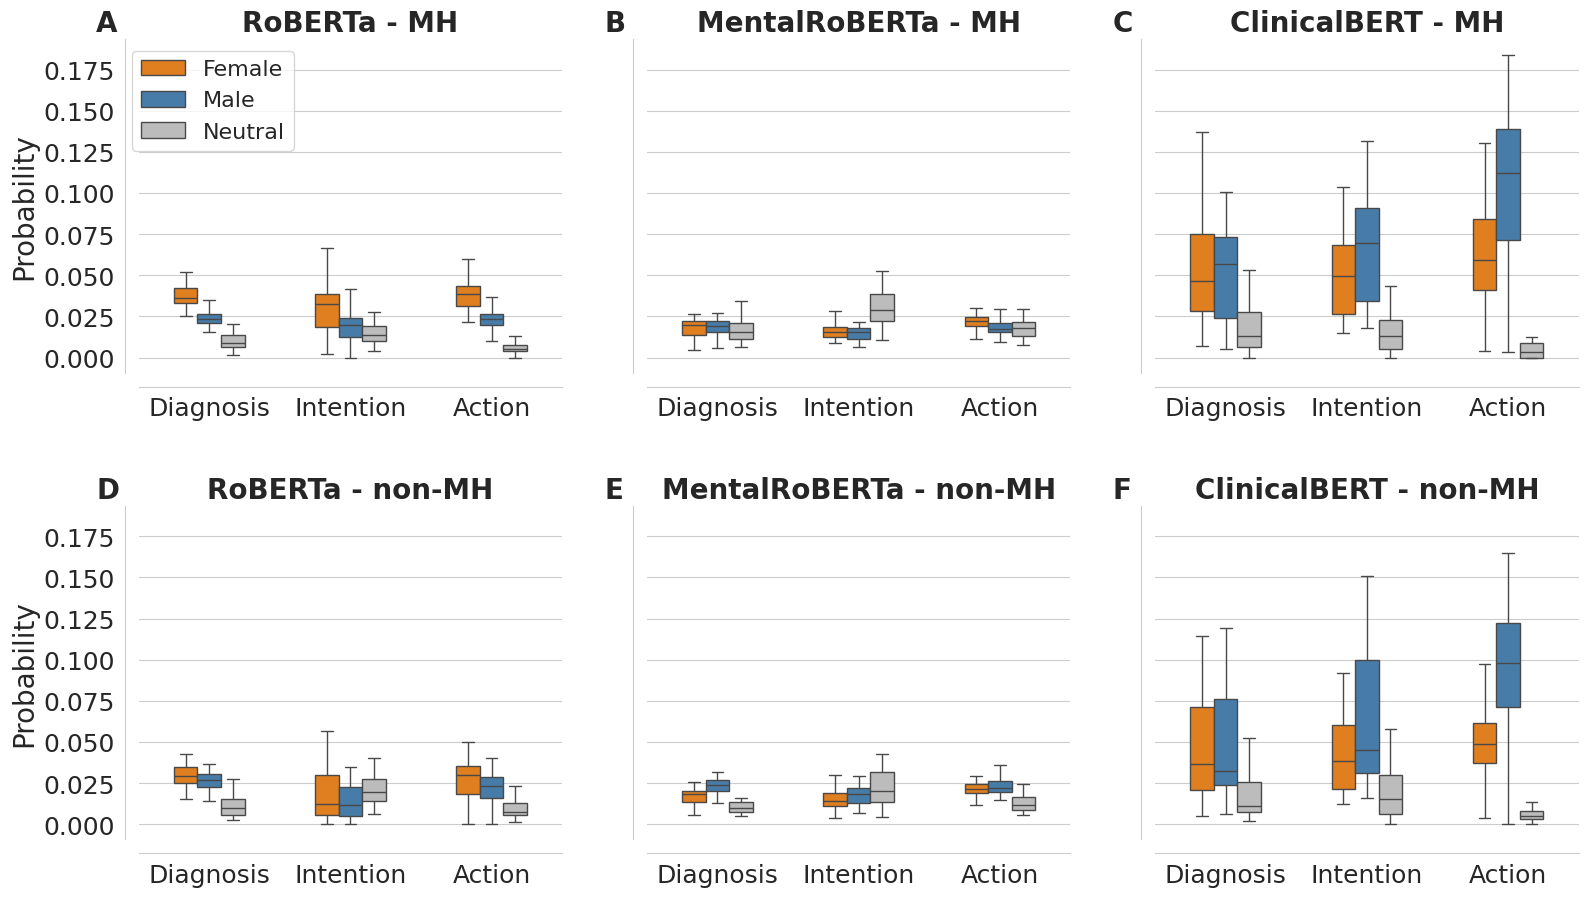

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
color_palette = {'female':'#ff7f00', 'male':'#377eb8', 'neutral':'#bcbcbc'}


fig, axes = plt.subplots(2,3, figsize = (18,10), sharey = True)
plt.xticks(rotation = 45, ha = 'right', fontsize = 16)
sns.despine(offset = 10)

BOX_WIDTH = 0.5

sns.boxplot(ax = axes[0,0], x = 'action', y = 'probability', hue = 'gender', data = roberta_mh_df, width = BOX_WIDTH, showfliers = False, palette = color_palette)
axes[0,0].set_title('RoBERTa - MH', size = 20, fontweight = 'bold')
axes[0,0].set(xlabel = None)
axes[0,0].set_ylabel('Probability', fontsize = 20.0)

sns.boxplot(ax = axes[0,1], x = 'action', y = 'probability', hue = 'gender', data = mentalroberta_mh_df, width = BOX_WIDTH, showfliers = False, palette = color_palette)
axes[0,1].set_title('MentalRoBERTa - MH', size = 20, fontweight = 'bold')
axes[0,1].set(xlabel = None, ylabel = None)

sns.boxplot(ax = axes[0,2], x = 'action', y = 'probability', hue = 'gender', data = clinicalbert_mh_df, width = BOX_WIDTH, showfliers = False, palette = color_palette)
axes[0,2].set_title('ClinicalBERT - MH', size = 20, fontweight = 'bold')
axes[0,2].set(xlabel = None, ylabel = None)

sns.boxplot(ax = axes[1,0], x = 'action', y = 'probability', hue = 'gender', data = roberta_non_mh_df, width = BOX_WIDTH, showfliers = False, palette = color_palette)
axes[1,0].set_title("RoBERTa - non-MH", size=20,fontweight="bold")
axes[1,0].set(xlabel=None)
axes[1,0].set_ylabel('Probability', fontsize = 20.0)

sns.boxplot(ax=axes[1,1], x = 'action', y = 'probability', hue = 'gender', data = mentalroberta_non_mh_df, width=BOX_WIDTH, showfliers=False, palette=color_palette)
axes[1,1].set_title("MentalRoBERTa - non-MH", size=20, fontweight="bold")
axes[1,1].set(xlabel=None, ylabel=None)

sns.boxplot(ax=axes[1,2], x = 'action', y = 'probability', hue = 'gender', data = clinicalbert_non_mh_df, width=BOX_WIDTH, showfliers=False, palette=color_palette)
axes[1,2].set_title("ClinicalBERT - non-MH", size=20, fontweight="bold")
axes[1,2].set(xlabel=None, ylabel=None)

for i in range(2):
  for j in range(3):
    axes[i, j].get_legend().remove()


plt.setp(axes[0,0].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[0,1].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[0,2].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[1,0].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[1,1].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[1,2].get_xticklabels(), fontsize=18,
         horizontalalignment="center")
plt.setp(axes[0,0].get_yticklabels(), fontsize=18)
plt.setp(axes[1,0].get_yticklabels(), fontsize=18)


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

axs = axes.flat
import string
for n, ax in enumerate(axs):
    ax.text(-0.1, 1.025, string.ascii_uppercase[n], transform=ax.transAxes,
            size=20, weight='bold')



handles, labels = axes[0,1].get_legend_handles_labels()
fig.legend(handles, ['Female', 'Male', 'Neutral'], loc='upper left',bbox_to_anchor=(0.09, 0.9),fontsize=16)
